## Attention is All you Need

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [41]:
def scaled_dot_product_attention(Q, K, V, mask=None, dropout=None):
    """
    Compute scaled dot-product attention.
    
    Args:
        Q: Query matrix (batch_size, seq_len, d_k)
        K: Key matrix (batch_size, seq_len, d_k)
        V: Value matrix (batch_size, seq_len, d_v)
        mask: Optional mask (batch_size, seq_len, seq_len)
        dropout: Optional dropout layer
    
    Returns:
        output: Attention output (batch_size, seq_len, d_v)
        attention_weights: Attention weights (batch_size, seq_len, seq_len)
    """
    d_k = Q.size(-1)
    
    # Compute attention scores
    scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_k)
    
    # Apply mask if provided
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    
    # Apply softmax
    attention_weights = F.softmax(scores, dim=-1)
    
    # Apply dropout if provided
    if dropout is not None:
        attention_weights = dropout(attention_weights)
    
    # Apply attention to values
    output = torch.matmul(attention_weights, V)
    
    return output, attention_weights

In [42]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        # Linear layers for Q, K, V
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)
        
        # Linear transformations and split into heads
        Q = self.W_q(query).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(key).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(value).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        
        # Apply attention
        attention_output, attention_weights = scaled_dot_product_attention(
            Q, K, V, mask=mask, dropout=self.dropout
        )
        
        # Concatenate heads
        attention_output = attention_output.transpose(1, 2).contiguous().view(
            batch_size, -1, self.d_model
        )
        
        # Final linear layer
        output = self.W_o(attention_output)
        
        return output, attention_weights

In [43]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

In [44]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * 
                           (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        return x + self.pe[:x.size(0), :]

In [45]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.self_attention = MultiHeadAttention(d_model, num_heads, dropout)
        self.feed_forward = PositionwiseFeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask=None):
        # Self-attention with residual connection
        attn_output, _ = self.self_attention(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        
        # Feed-forward with residual connection
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        
        return x

In [46]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.self_attention = MultiHeadAttention(d_model, num_heads, dropout)
        self.cross_attention = MultiHeadAttention(d_model, num_heads, dropout)
        self.feed_forward = PositionwiseFeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, encoder_output, src_mask=None, tgt_mask=None):
        # Masked self-attention
        attn_output, _ = self.self_attention(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        
        # Cross-attention
        attn_output, attention_weights = self.cross_attention(x, encoder_output, encoder_output, src_mask)
        x = self.norm2(x + self.dropout(attn_output))
        
        # Feed-forward
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        
        return x, attention_weights

In [47]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model=512, num_heads=8, 
                 num_layers=6, d_ff=2048, max_len=5000, dropout=0.1):
        super(Transformer, self).__init__()
        
        self.d_model = d_model
        
        # Embeddings
        self.src_embedding = nn.Embedding(src_vocab_size, d_model)
        self.tgt_embedding = nn.Embedding(tgt_vocab_size, d_model)
        
        # Positional encoding
        self.pos_encoding = PositionalEncoding(d_model, max_len)
        
        # Encoder layers
        self.encoder_layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, d_ff, dropout) 
            for _ in range(num_layers)
        ])
        
        # Decoder layers
        self.decoder_layers = nn.ModuleList([
            DecoderLayer(d_model, num_heads, d_ff, dropout) 
            for _ in range(num_layers)
        ])
        
        # Final linear layer
        self.linear = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)
        
    def encode(self, src, src_mask=None):
        # Embedding + positional encoding
        src_emb = self.src_embedding(src) * math.sqrt(self.d_model)
        src_emb = self.pos_encoding(src_emb)
        src_emb = self.dropout(src_emb)
        
        # Pass through encoder layers
        encoder_output = src_emb
        for layer in self.encoder_layers:
            encoder_output = layer(encoder_output, src_mask)
            
        return encoder_output
    
    def decode(self, tgt, encoder_output, src_mask=None, tgt_mask=None):
        # Embedding + positional encoding
        tgt_emb = self.tgt_embedding(tgt) * math.sqrt(self.d_model)
        tgt_emb = self.pos_encoding(tgt_emb)
        tgt_emb = self.dropout(tgt_emb)
        
        # Pass through decoder layers
        decoder_output = tgt_emb
        attention_weights = []
        for layer in self.decoder_layers:
            decoder_output, attn_weights = layer(decoder_output, encoder_output, src_mask, tgt_mask)
            attention_weights.append(attn_weights)
            
        return decoder_output, attention_weights
    
    def forward(self, src, tgt, src_mask=None, tgt_mask=None):
        encoder_output = self.encode(src, src_mask)
        decoder_output, attention_weights = self.decode(tgt, encoder_output, src_mask, tgt_mask)
        output = self.linear(decoder_output)
        return output, attention_weights

In [48]:
def create_padding_mask(seq, pad_idx=0):
    """Create mask to hide padding tokens"""
    return (seq != pad_idx).unsqueeze(1).unsqueeze(2)

In [49]:
def create_look_ahead_mask(size):
    """Create mask to prevent looking at future tokens"""
    mask = torch.triu(torch.ones(size, size), diagonal=1)
    return mask == 0

In [50]:
def create_masks(src, tgt, pad_idx=0):
    """Create all masks needed for training"""
    src_mask = create_padding_mask(src, pad_idx)
    
    tgt_mask = create_padding_mask(tgt, pad_idx)
    look_ahead_mask = create_look_ahead_mask(tgt.size(1)).to(src.device)
    tgt_mask = tgt_mask & look_ahead_mask.unsqueeze(0)
    
    return src_mask, tgt_mask

In [51]:
# Dataset creation
class SimpleTranslationDataset(Dataset):
    def __init__(self, num_samples=1000, max_len=20):
        """
        Create a simple synthetic dataset for demonstration.
        Task: Reverse the input sequence (e.g., [1,2,3,4] -> [4,3,2,1])
        """
        self.num_samples = num_samples
        self.max_len = max_len
        self.vocab_size = 100
        self.pad_idx = 0
        self.sos_idx = 1
        self.eos_idx = 2
        
        # Generate synthetic data
        self.data = []
        for _ in range(num_samples):
            # Random sequence length
            seq_len = np.random.randint(3, max_len - 2)
            
            # Random sequence (avoid special tokens)
            src_seq = np.random.randint(3, self.vocab_size, seq_len)
            
            # Target is reversed sequence with SOS and EOS
            tgt_seq = np.concatenate([[self.sos_idx], src_seq[::-1], [self.eos_idx]])
            
            # Pad sequences
            src_padded = np.pad(src_seq, (0, max_len - len(src_seq)), constant_values=self.pad_idx)
            tgt_padded = np.pad(tgt_seq, (0, max_len - len(tgt_seq)), constant_values=self.pad_idx)
            
            self.data.append((src_padded, tgt_padded))
    
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        src, tgt = self.data[idx]
        return torch.tensor(src, dtype=torch.long), torch.tensor(tgt, dtype=torch.long)


In [52]:
train_dataset = SimpleTranslationDataset(num_samples=2000, max_len=15)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [53]:
len(train_dataset), train_dataset.vocab_size

(2000, 100)

In [54]:
# Model hyperparameters
d_model = 256
num_heads = 8
num_layers = 4
d_ff = 512
dropout = 0.1
vocab_size = train_dataset.vocab_size

In [55]:
# Initialize model
model = Transformer(
    src_vocab_size=vocab_size,
    tgt_vocab_size=vocab_size,
    d_model=d_model,
    num_heads=num_heads,
    num_layers=num_layers,
    d_ff=d_ff,
    dropout=dropout
).to(device)

In [56]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=train_dataset.pad_idx)
optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

In [57]:
def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    
    for batch_idx, (src, tgt) in enumerate(tqdm(dataloader, desc="Training")):
        src, tgt = src.to(device), tgt.to(device)
        
        # Prepare input and target
        tgt_input = tgt[:, :-1]  # Remove last token for input
        tgt_output = tgt[:, 1:]  # Remove first token for target
        
        # Create masks
        src_mask, tgt_mask = create_masks(src, tgt_input, train_dataset.pad_idx)
        src_mask = src_mask.to(device)
        tgt_mask = tgt_mask.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        output, _ = model(src, tgt_input, src_mask, tgt_mask)
        
        # Calculate loss
        loss = criterion(output.reshape(-1, vocab_size), tgt_output.reshape(-1))
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        if batch_idx % 20 == 0:
            print(f'Batch {batch_idx}, Loss: {loss.item():.4f}')
    
    return total_loss / len(dataloader)

In [58]:
# Train the model
num_epochs = 50
train_losses = []

In [59]:
print("Starting training...")
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    avg_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    train_losses.append(avg_loss)
    print(f"Average Loss: {avg_loss:.4f}")

Starting training...

Epoch 1/50


Training:   3%|▎         | 2/63 [00:00<00:03, 17.69it/s]

Batch 0, Loss: 4.8015


Training:  33%|███▎      | 21/63 [00:01<00:04,  9.51it/s]

Batch 20, Loss: 4.4112


Training:  73%|███████▎  | 46/63 [00:03<00:00, 20.86it/s]

Batch 40, Loss: 4.2397


Training: 100%|██████████| 63/63 [00:04<00:00, 15.08it/s]


Batch 60, Loss: 4.0929
Average Loss: 4.2877

Epoch 2/50


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Batch 0, Loss: 3.9017


Training:  35%|███▍      | 22/63 [00:01<00:02, 19.40it/s]

Batch 20, Loss: 3.7127


Training:  70%|██████▉   | 44/63 [00:02<00:01, 14.11it/s]

Batch 40, Loss: 3.7102


Training:  97%|█████████▋| 61/63 [00:04<00:00, 10.99it/s]

Batch 60, Loss: 3.5076


Training: 100%|██████████| 63/63 [00:04<00:00, 14.03it/s]


Average Loss: 3.6615

Epoch 3/50


Training:   2%|▏         | 1/63 [00:00<00:09,  6.32it/s]

Batch 0, Loss: 3.3987


Training:  38%|███▊      | 24/63 [00:01<00:01, 21.10it/s]

Batch 20, Loss: 3.2727


Training:  68%|██████▊   | 43/63 [00:02<00:01, 13.70it/s]

Batch 40, Loss: 3.1718


Training: 100%|██████████| 63/63 [00:04<00:00, 14.17it/s]


Batch 60, Loss: 3.2199
Average Loss: 3.2145

Epoch 4/50


Training:   5%|▍         | 3/63 [00:00<00:05, 10.52it/s]

Batch 0, Loss: 3.0950


Training:  37%|███▋      | 23/63 [00:02<00:03, 11.73it/s]

Batch 20, Loss: 3.0336


Training:  67%|██████▋   | 42/63 [00:03<00:00, 21.26it/s]

Batch 40, Loss: 2.9263


Training: 100%|██████████| 63/63 [00:04<00:00, 14.35it/s]


Batch 60, Loss: 2.7895
Average Loss: 2.9470

Epoch 5/50


Training:   5%|▍         | 3/63 [00:00<00:05, 11.07it/s]

Batch 0, Loss: 2.7382


Training:  37%|███▋      | 23/63 [00:01<00:03, 12.87it/s]

Batch 20, Loss: 2.6899


Training:  70%|██████▉   | 44/63 [00:03<00:01, 13.96it/s]

Batch 40, Loss: 2.6422


Training: 100%|██████████| 63/63 [00:04<00:00, 12.62it/s]


Batch 60, Loss: 2.7610
Average Loss: 2.7620

Epoch 6/50


Training:   3%|▎         | 2/63 [00:00<00:06,  9.05it/s]

Batch 0, Loss: 2.6912


Training:  37%|███▋      | 23/63 [00:02<00:02, 17.05it/s]

Batch 20, Loss: 2.5150


Training:  73%|███████▎  | 46/63 [00:03<00:00, 19.06it/s]

Batch 40, Loss: 2.5751


Training: 100%|██████████| 63/63 [00:04<00:00, 14.96it/s]


Batch 60, Loss: 2.5184
Average Loss: 2.6130

Epoch 7/50


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Batch 0, Loss: 2.6402


Training:  40%|███▉      | 25/63 [00:01<00:01, 23.49it/s]

Batch 20, Loss: 2.4968


Training:  68%|██████▊   | 43/63 [00:02<00:01, 16.96it/s]

Batch 40, Loss: 2.4995


Training: 100%|██████████| 63/63 [00:03<00:00, 17.39it/s]


Batch 60, Loss: 2.4139
Average Loss: 2.4868

Epoch 8/50


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Batch 0, Loss: 2.3700


Training:  33%|███▎      | 21/63 [00:01<00:03, 10.62it/s]

Batch 20, Loss: 2.4527


Training:  68%|██████▊   | 43/63 [00:03<00:01, 16.58it/s]

Batch 40, Loss: 2.3539


Training:  98%|█████████▊| 62/63 [00:05<00:00,  9.07it/s]

Batch 60, Loss: 2.3143


Training: 100%|██████████| 63/63 [00:05<00:00, 12.00it/s]


Average Loss: 2.3725

Epoch 9/50


Training:   2%|▏         | 1/63 [00:00<00:08,  6.95it/s]

Batch 0, Loss: 2.0454


Training:  38%|███▊      | 24/63 [00:01<00:02, 16.93it/s]

Batch 20, Loss: 2.4799


Training:  67%|██████▋   | 42/63 [00:02<00:01, 11.83it/s]

Batch 40, Loss: 2.3410


Training: 100%|██████████| 63/63 [00:04<00:00, 15.60it/s]


Batch 60, Loss: 2.2240
Average Loss: 2.2636

Epoch 10/50


Training:   3%|▎         | 2/63 [00:00<00:04, 12.85it/s]

Batch 0, Loss: 2.2809


Training:  35%|███▍      | 22/63 [00:01<00:03, 11.65it/s]

Batch 20, Loss: 2.1070


Training:  67%|██████▋   | 42/63 [00:03<00:01, 14.46it/s]

Batch 40, Loss: 2.1859


Training: 100%|██████████| 63/63 [00:05<00:00, 12.43it/s]


Batch 60, Loss: 2.1209
Average Loss: 2.1769

Epoch 11/50


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Batch 0, Loss: 2.0823


Training:  33%|███▎      | 21/63 [00:01<00:03, 12.18it/s]

Batch 20, Loss: 1.9786


Training:  68%|██████▊   | 43/63 [00:03<00:01, 14.39it/s]

Batch 40, Loss: 2.0679


Training: 100%|██████████| 63/63 [00:04<00:00, 12.82it/s]


Batch 60, Loss: 2.0586
Average Loss: 2.0834

Epoch 12/50


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Batch 0, Loss: 2.0579


Training:  40%|███▉      | 25/63 [00:01<00:01, 19.65it/s]

Batch 20, Loss: 2.0214


Training:  67%|██████▋   | 42/63 [00:02<00:00, 21.76it/s]

Batch 40, Loss: 1.8611


Training: 100%|██████████| 63/63 [00:03<00:00, 17.74it/s]


Batch 60, Loss: 2.0541
Average Loss: 1.9920

Epoch 13/50


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Batch 0, Loss: 1.9477


Training:  35%|███▍      | 22/63 [00:01<00:02, 14.92it/s]

Batch 20, Loss: 1.9175


Training:  68%|██████▊   | 43/63 [00:03<00:01, 17.70it/s]

Batch 40, Loss: 1.7600


Training: 100%|██████████| 63/63 [00:04<00:00, 14.35it/s]


Batch 60, Loss: 1.8090
Average Loss: 1.9189

Epoch 14/50


Training:   3%|▎         | 2/63 [00:00<00:04, 12.25it/s]

Batch 0, Loss: 1.9743


Training:  38%|███▊      | 24/63 [00:01<00:02, 16.40it/s]

Batch 20, Loss: 1.7806


Training:  70%|██████▉   | 44/63 [00:02<00:01, 17.88it/s]

Batch 40, Loss: 1.8396


Training: 100%|██████████| 63/63 [00:03<00:00, 16.25it/s]


Batch 60, Loss: 1.8606
Average Loss: 1.8363

Epoch 15/50


Training:   5%|▍         | 3/63 [00:00<00:05, 10.88it/s]

Batch 0, Loss: 1.7568


Training:  33%|███▎      | 21/63 [00:01<00:04,  9.86it/s]

Batch 20, Loss: 1.7295


Training:  73%|███████▎  | 46/63 [00:04<00:01, 15.06it/s]

Batch 40, Loss: 1.7545


Training: 100%|██████████| 63/63 [00:06<00:00, 10.04it/s]


Batch 60, Loss: 1.8619
Average Loss: 1.7723

Epoch 16/50


Training:   5%|▍         | 3/63 [00:00<00:05, 10.91it/s]

Batch 0, Loss: 1.7674


Training:  37%|███▋      | 23/63 [00:01<00:02, 14.92it/s]

Batch 20, Loss: 1.6111


Training:  70%|██████▉   | 44/63 [00:03<00:01, 15.63it/s]

Batch 40, Loss: 1.7681


Training: 100%|██████████| 63/63 [00:04<00:00, 12.91it/s]


Batch 60, Loss: 1.5587
Average Loss: 1.6959

Epoch 17/50


Training:   8%|▊         | 5/63 [00:00<00:02, 21.20it/s]

Batch 0, Loss: 1.6367


Training:  35%|███▍      | 22/63 [00:01<00:03, 13.48it/s]

Batch 20, Loss: 1.6502


Training:  71%|███████▏  | 45/63 [00:02<00:00, 20.49it/s]

Batch 40, Loss: 1.7789


Training: 100%|██████████| 63/63 [00:04<00:00, 15.50it/s]


Batch 60, Loss: 1.6275
Average Loss: 1.6433

Epoch 18/50


Training:   5%|▍         | 3/63 [00:00<00:05, 11.19it/s]

Batch 0, Loss: 1.7105


Training:  40%|███▉      | 25/63 [00:02<00:02, 13.48it/s]

Batch 20, Loss: 1.5659


Training:  68%|██████▊   | 43/63 [00:03<00:01, 13.80it/s]

Batch 40, Loss: 1.6717


Training: 100%|██████████| 63/63 [00:04<00:00, 12.84it/s]


Batch 60, Loss: 1.5773
Average Loss: 1.5757

Epoch 19/50


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Batch 0, Loss: 1.5364


Training:  37%|███▋      | 23/63 [00:02<00:04,  8.79it/s]

Batch 20, Loss: 1.4242


Training:  68%|██████▊   | 43/63 [00:03<00:01, 12.08it/s]

Batch 40, Loss: 1.5621


Training: 100%|██████████| 63/63 [00:05<00:00, 12.26it/s]


Batch 60, Loss: 1.5375
Average Loss: 1.5134

Epoch 20/50


Training:   3%|▎         | 2/63 [00:00<00:03, 18.80it/s]

Batch 0, Loss: 1.5345


Training:  33%|███▎      | 21/63 [00:01<00:02, 16.69it/s]

Batch 20, Loss: 1.3658


Training:  70%|██████▉   | 44/63 [00:03<00:01, 18.13it/s]

Batch 40, Loss: 1.4811


Training: 100%|██████████| 63/63 [00:04<00:00, 14.37it/s]


Batch 60, Loss: 1.4480
Average Loss: 1.4667

Epoch 21/50


Training:   5%|▍         | 3/63 [00:00<00:02, 25.85it/s]

Batch 0, Loss: 1.4854


Training:  33%|███▎      | 21/63 [00:01<00:03, 13.62it/s]

Batch 20, Loss: 1.5141


Training:  70%|██████▉   | 44/63 [00:03<00:01, 13.98it/s]

Batch 40, Loss: 1.4927


Training:  98%|█████████▊| 62/63 [00:04<00:00,  7.82it/s]

Batch 60, Loss: 1.5757


Training: 100%|██████████| 63/63 [00:04<00:00, 12.67it/s]


Average Loss: 1.4109

Epoch 22/50


Training:   2%|▏         | 1/63 [00:00<00:06,  9.09it/s]

Batch 0, Loss: 1.4120


Training:  35%|███▍      | 22/63 [00:02<00:04,  8.24it/s]

Batch 20, Loss: 1.3352


Training:  68%|██████▊   | 43/63 [00:03<00:01, 12.41it/s]

Batch 40, Loss: 1.3968


Training: 100%|██████████| 63/63 [00:04<00:00, 13.02it/s]


Batch 60, Loss: 1.3271
Average Loss: 1.3497

Epoch 23/50


Training:   3%|▎         | 2/63 [00:00<00:03, 19.53it/s]

Batch 0, Loss: 1.3466


Training:  33%|███▎      | 21/63 [00:01<00:04,  8.70it/s]

Batch 20, Loss: 1.2500


Training:  68%|██████▊   | 43/63 [00:03<00:01, 12.32it/s]

Batch 40, Loss: 1.3149


Training: 100%|██████████| 63/63 [00:04<00:00, 12.87it/s]


Batch 60, Loss: 1.3150
Average Loss: 1.3019

Epoch 24/50


Training:   3%|▎         | 2/63 [00:00<00:03, 19.45it/s]

Batch 0, Loss: 1.1717


Training:  41%|████▏     | 26/63 [00:01<00:01, 24.11it/s]

Batch 20, Loss: 1.3250


Training:  67%|██████▋   | 42/63 [00:02<00:01, 14.70it/s]

Batch 40, Loss: 1.3244


Training: 100%|██████████| 63/63 [00:04<00:00, 15.57it/s]


Batch 60, Loss: 1.2250
Average Loss: 1.2524

Epoch 25/50


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Batch 0, Loss: 1.0853


Training:  35%|███▍      | 22/63 [00:00<00:01, 23.52it/s]

Batch 20, Loss: 1.2085


Training:  70%|██████▉   | 44/63 [00:02<00:00, 22.41it/s]

Batch 40, Loss: 1.1422


Training: 100%|██████████| 63/63 [00:03<00:00, 16.55it/s]


Batch 60, Loss: 1.2714
Average Loss: 1.2104

Epoch 26/50


Training:   3%|▎         | 2/63 [00:00<00:05, 12.00it/s]

Batch 0, Loss: 1.0790


Training:  35%|███▍      | 22/63 [00:01<00:04, 10.08it/s]

Batch 20, Loss: 1.1249


Training:  67%|██████▋   | 42/63 [00:04<00:02,  8.75it/s]

Batch 40, Loss: 1.0961


Training: 100%|██████████| 63/63 [00:05<00:00, 11.78it/s]


Batch 60, Loss: 1.1955
Average Loss: 1.1675

Epoch 27/50


Training:   3%|▎         | 2/63 [00:00<00:03, 19.42it/s]

Batch 0, Loss: 1.0838


Training:  38%|███▊      | 24/63 [00:01<00:01, 20.02it/s]

Batch 20, Loss: 1.1860


Training:  67%|██████▋   | 42/63 [00:02<00:01, 17.93it/s]

Batch 40, Loss: 1.1943


Training: 100%|██████████| 63/63 [00:03<00:00, 15.91it/s]


Batch 60, Loss: 1.1092
Average Loss: 1.1217

Epoch 28/50


Training:   5%|▍         | 3/63 [00:00<00:05, 10.74it/s]

Batch 0, Loss: 1.1405


Training:  37%|███▋      | 23/63 [00:01<00:03, 11.40it/s]

Batch 20, Loss: 1.0715


Training:  63%|██████▎   | 40/63 [00:03<00:01, 18.64it/s]

Batch 40, Loss: 1.0992


Training:  98%|█████████▊| 62/63 [00:05<00:00,  7.52it/s]

Batch 60, Loss: 1.1377


Training: 100%|██████████| 63/63 [00:05<00:00, 11.19it/s]


Average Loss: 1.0925

Epoch 29/50


Training:   2%|▏         | 1/63 [00:00<00:06,  8.95it/s]

Batch 0, Loss: 1.0203


Training:  37%|███▋      | 23/63 [00:01<00:02, 16.78it/s]

Batch 20, Loss: 1.0973


Training:  67%|██████▋   | 42/63 [00:02<00:01, 11.35it/s]

Batch 40, Loss: 1.0788


Training: 100%|██████████| 63/63 [00:04<00:00, 14.87it/s]

Batch 60, Loss: 1.1074
Average Loss: 1.0422

Epoch 30/50



Training:   5%|▍         | 3/63 [00:00<00:05, 11.03it/s]

Batch 0, Loss: 1.0587


Training:  38%|███▊      | 24/63 [00:01<00:02, 16.17it/s]

Batch 20, Loss: 1.0192


Training:  67%|██████▋   | 42/63 [00:02<00:01, 15.67it/s]

Batch 40, Loss: 0.9969


Training:  97%|█████████▋| 61/63 [00:04<00:00, 15.70it/s]

Batch 60, Loss: 1.0720


Training: 100%|██████████| 63/63 [00:04<00:00, 14.12it/s]


Average Loss: 1.0087

Epoch 31/50


Training:   2%|▏         | 1/63 [00:00<00:09,  6.87it/s]

Batch 0, Loss: 0.9527


Training:  37%|███▋      | 23/63 [00:01<00:02, 13.68it/s]

Batch 20, Loss: 0.8593


Training:  70%|██████▉   | 44/63 [00:02<00:01, 17.87it/s]

Batch 40, Loss: 0.9725


Training: 100%|██████████| 63/63 [00:03<00:00, 15.79it/s]


Batch 60, Loss: 1.0548
Average Loss: 0.9691

Epoch 32/50


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Batch 0, Loss: 0.7016


Training:  35%|███▍      | 22/63 [00:01<00:02, 15.87it/s]

Batch 20, Loss: 0.8885


Training:  67%|██████▋   | 42/63 [00:02<00:01, 13.70it/s]

Batch 40, Loss: 0.9709


Training: 100%|██████████| 63/63 [00:03<00:00, 16.43it/s]


Batch 60, Loss: 0.9141
Average Loss: 0.9392

Epoch 33/50


Training:   6%|▋         | 4/63 [00:00<00:03, 16.05it/s]

Batch 0, Loss: 0.8603


Training:  40%|███▉      | 25/63 [00:01<00:01, 20.41it/s]

Batch 20, Loss: 0.8886


Training:  70%|██████▉   | 44/63 [00:02<00:00, 20.39it/s]

Batch 40, Loss: 0.9167


Training: 100%|██████████| 63/63 [00:03<00:00, 18.35it/s]


Batch 60, Loss: 0.8888
Average Loss: 0.9022

Epoch 34/50


Training:   3%|▎         | 2/63 [00:00<00:05, 11.80it/s]

Batch 0, Loss: 0.8679


Training:  38%|███▊      | 24/63 [00:01<00:02, 16.39it/s]

Batch 20, Loss: 0.7733


Training:  68%|██████▊   | 43/63 [00:02<00:00, 21.34it/s]

Batch 40, Loss: 0.8119


Training: 100%|██████████| 63/63 [00:03<00:00, 16.04it/s]


Batch 60, Loss: 0.8503
Average Loss: 0.8663

Epoch 35/50


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Batch 0, Loss: 0.8674


Training:  38%|███▊      | 24/63 [00:01<00:02, 18.11it/s]

Batch 20, Loss: 0.8742


Training:  68%|██████▊   | 43/63 [00:02<00:01, 19.44it/s]

Batch 40, Loss: 0.8770


Training: 100%|██████████| 63/63 [00:03<00:00, 17.36it/s]


Batch 60, Loss: 0.8928
Average Loss: 0.8357

Epoch 36/50


Training:   3%|▎         | 2/63 [00:00<00:06,  9.52it/s]

Batch 0, Loss: 0.6836


Training:  37%|███▋      | 23/63 [00:01<00:02, 18.78it/s]

Batch 20, Loss: 0.8433


Training:  70%|██████▉   | 44/63 [00:02<00:01, 16.43it/s]

Batch 40, Loss: 0.8389


Training: 100%|██████████| 63/63 [00:03<00:00, 18.37it/s]


Batch 60, Loss: 0.8558
Average Loss: 0.8011

Epoch 37/50


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Batch 0, Loss: 0.5793


Training:  38%|███▊      | 24/63 [00:01<00:02, 17.56it/s]

Batch 20, Loss: 0.7169


Training:  68%|██████▊   | 43/63 [00:02<00:00, 20.56it/s]

Batch 40, Loss: 0.8418


Training: 100%|██████████| 63/63 [00:03<00:00, 19.06it/s]


Batch 60, Loss: 0.7932
Average Loss: 0.7688

Epoch 38/50


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Batch 0, Loss: 0.6911


Training:  35%|███▍      | 22/63 [00:01<00:01, 21.41it/s]

Batch 20, Loss: 0.7527


Training:  68%|██████▊   | 43/63 [00:02<00:01, 18.44it/s]

Batch 40, Loss: 0.8197


Training: 100%|██████████| 63/63 [00:04<00:00, 15.32it/s]


Batch 60, Loss: 0.7438
Average Loss: 0.7442

Epoch 39/50


Training:   3%|▎         | 2/63 [00:00<00:05, 10.57it/s]

Batch 0, Loss: 0.7056


Training:  40%|███▉      | 25/63 [00:02<00:02, 13.01it/s]

Batch 20, Loss: 0.6731


Training:  68%|██████▊   | 43/63 [00:03<00:01, 18.86it/s]

Batch 40, Loss: 0.7395


Training: 100%|██████████| 63/63 [00:04<00:00, 15.09it/s]


Batch 60, Loss: 0.7877
Average Loss: 0.7121

Epoch 40/50


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Batch 0, Loss: 0.7727


Training:  38%|███▊      | 24/63 [00:01<00:02, 19.36it/s]

Batch 20, Loss: 0.7010


Training:  70%|██████▉   | 44/63 [00:02<00:01, 17.70it/s]

Batch 40, Loss: 0.7423


Training: 100%|██████████| 63/63 [00:03<00:00, 17.31it/s]


Batch 60, Loss: 0.7307
Average Loss: 0.6940

Epoch 41/50


Training:   3%|▎         | 2/63 [00:00<00:04, 12.30it/s]

Batch 0, Loss: 0.5934


Training:  38%|███▊      | 24/63 [00:01<00:02, 19.47it/s]

Batch 20, Loss: 0.6396


Training:  67%|██████▋   | 42/63 [00:02<00:01, 15.14it/s]

Batch 40, Loss: 0.7465


Training: 100%|██████████| 63/63 [00:04<00:00, 15.33it/s]


Batch 60, Loss: 0.6702
Average Loss: 0.6590

Epoch 42/50


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Batch 0, Loss: 0.6042


Training:  38%|███▊      | 24/63 [00:01<00:02, 18.38it/s]

Batch 20, Loss: 0.5768


Training:  68%|██████▊   | 43/63 [00:02<00:01, 11.90it/s]

Batch 40, Loss: 0.6300


Training: 100%|██████████| 63/63 [00:04<00:00, 15.10it/s]


Batch 60, Loss: 0.7109
Average Loss: 0.6402

Epoch 43/50


Training:   5%|▍         | 3/63 [00:00<00:05, 10.84it/s]

Batch 0, Loss: 0.6771


Training:  37%|███▋      | 23/63 [00:01<00:01, 21.61it/s]

Batch 20, Loss: 0.5820


Training:  67%|██████▋   | 42/63 [00:02<00:01, 12.39it/s]

Batch 40, Loss: 0.6232


Training:  98%|█████████▊| 62/63 [00:04<00:00, 10.62it/s]

Batch 60, Loss: 0.6173


Training: 100%|██████████| 63/63 [00:04<00:00, 13.27it/s]


Average Loss: 0.6257

Epoch 44/50


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Batch 0, Loss: 0.5431


Training:  37%|███▋      | 23/63 [00:01<00:02, 16.09it/s]

Batch 20, Loss: 0.5928


Training:  70%|██████▉   | 44/63 [00:02<00:01, 16.58it/s]

Batch 40, Loss: 0.7129


Training: 100%|██████████| 63/63 [00:04<00:00, 12.87it/s]


Batch 60, Loss: 0.6124
Average Loss: 0.5928

Epoch 45/50


Training:   3%|▎         | 2/63 [00:00<00:06,  9.83it/s]

Batch 0, Loss: 0.4820


Training:  35%|███▍      | 22/63 [00:01<00:03, 12.11it/s]

Batch 20, Loss: 0.5245


Training:  65%|██████▌   | 41/63 [00:03<00:01, 16.31it/s]

Batch 40, Loss: 0.5644


Training:  98%|█████████▊| 62/63 [00:04<00:00, 11.18it/s]

Batch 60, Loss: 0.5754


Training: 100%|██████████| 63/63 [00:04<00:00, 13.02it/s]


Average Loss: 0.5590

Epoch 46/50


Training:   2%|▏         | 1/63 [00:00<00:08,  7.50it/s]

Batch 0, Loss: 0.4927


Training:  32%|███▏      | 20/63 [00:01<00:02, 20.08it/s]

Batch 20, Loss: 0.5359


Training:  67%|██████▋   | 42/63 [00:03<00:01, 10.54it/s]

Batch 40, Loss: 0.5842


Training: 100%|██████████| 63/63 [00:04<00:00, 14.90it/s]


Batch 60, Loss: 0.5891
Average Loss: 0.5541

Epoch 47/50


Training:   3%|▎         | 2/63 [00:00<00:04, 12.36it/s]

Batch 0, Loss: 0.5159


Training:  35%|███▍      | 22/63 [00:01<00:03, 11.68it/s]

Batch 20, Loss: 0.4863


Training:  63%|██████▎   | 40/63 [00:02<00:01, 20.86it/s]

Batch 40, Loss: 0.4841


Training: 100%|██████████| 63/63 [00:04<00:00, 15.45it/s]


Batch 60, Loss: 0.6344
Average Loss: 0.5259

Epoch 48/50


Training:   5%|▍         | 3/63 [00:00<00:05, 11.34it/s]

Batch 0, Loss: 0.3573


Training:  35%|███▍      | 22/63 [00:02<00:05,  7.41it/s]

Batch 20, Loss: 0.5468


Training:  68%|██████▊   | 43/63 [00:03<00:01, 13.49it/s]

Batch 40, Loss: 0.5629


Training: 100%|██████████| 63/63 [00:04<00:00, 13.10it/s]


Batch 60, Loss: 0.5561
Average Loss: 0.5041

Epoch 49/50


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Batch 0, Loss: 0.5144


Training:  33%|███▎      | 21/63 [00:01<00:02, 19.46it/s]

Batch 20, Loss: 0.4953


Training:  68%|██████▊   | 43/63 [00:02<00:00, 22.29it/s]

Batch 40, Loss: 0.5551


Training: 100%|██████████| 63/63 [00:03<00:00, 16.26it/s]


Batch 60, Loss: 0.4598
Average Loss: 0.4902

Epoch 50/50


Training:   3%|▎         | 2/63 [00:00<00:05, 11.60it/s]

Batch 0, Loss: 0.3985


Training:  35%|███▍      | 22/63 [00:01<00:03, 11.92it/s]

Batch 20, Loss: 0.5559


Training:  67%|██████▋   | 42/63 [00:03<00:01, 10.74it/s]

Batch 40, Loss: 0.4702


Training:  97%|█████████▋| 61/63 [00:05<00:00,  9.88it/s]

Batch 60, Loss: 0.5073


Training: 100%|██████████| 63/63 [00:05<00:00, 11.25it/s]

Average Loss: 0.4618


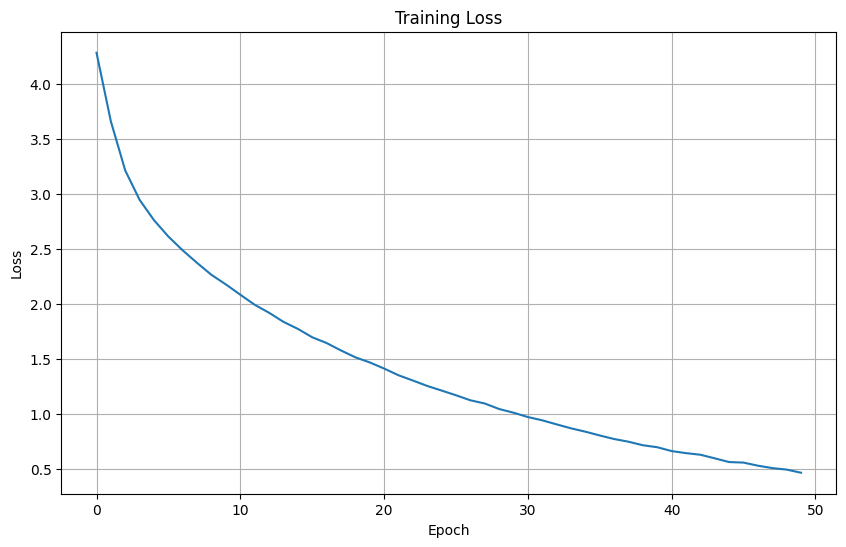

In [60]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


In [61]:
def greedy_decode(model, src, src_mask, max_len, start_symbol, end_symbol, device):
    """Simple greedy decoding for inference"""
    model.eval()
    
    encoder_output = model.encode(src, src_mask)
    
    # Initialize target sequence with start symbol
    tgt = torch.zeros(1, 1).fill_(start_symbol).type_as(src.data).to(device)
    
    for i in range(max_len - 1):
        tgt_mask = create_look_ahead_mask(tgt.size(1)).to(device)
        
        decoder_output, _ = model.decode(tgt, encoder_output, src_mask, tgt_mask)
        output = model.linear(decoder_output)
        
        # Get the next token
        next_token = output[:, -1, :].argmax(dim=-1).unsqueeze(0)
        tgt = torch.cat([tgt, next_token], dim=1)
        
        # Stop if end token is generated
        if next_token.item() == end_symbol:
            break
    
    return tgt

In [62]:
model.eval()
test_samples = 5

In [63]:
with torch.no_grad():
    for i in range(test_samples):
        src, tgt = train_dataset[i]
        src = src.unsqueeze(0).to(device)
        
        # Remove padding for display
        src_tokens = src.squeeze().cpu().numpy()
        src_tokens = src_tokens[src_tokens != train_dataset.pad_idx]
        
        tgt_tokens = tgt.cpu().numpy()
        tgt_tokens = tgt_tokens[tgt_tokens != train_dataset.pad_idx]
        
        # Create source mask
        src_mask = create_padding_mask(src, train_dataset.pad_idx).to(device)
        
        # Generate prediction
        pred = greedy_decode(
            model, src, src_mask, max_len=15, 
            start_symbol=train_dataset.sos_idx, 
            end_symbol=train_dataset.eos_idx, 
            device=device
        )
        
        pred_tokens = pred.squeeze().cpu().numpy()
        
        print(f"Sample {i+1}:")
        print(f"Source:     {src_tokens}")
        print(f"Target:     {tgt_tokens}")
        print(f"Predicted:  {pred_tokens}")
        print(f"Correct:    {np.array_equal(tgt_tokens, pred_tokens)}")
        print("-" * 30)


Sample 1:
Source:     [54 95 17 74 63 23 85 89 77]
Target:     [ 1 77 89 85 23 63 74 17 95 54  2]
Predicted:  [ 1 77 89 85 23 63 74 17 95 54  2]
Correct:    True
------------------------------
Sample 2:
Source:     [26  5 24 55  4 90 32 40  4 66]
Target:     [ 1 66  4 40 32 90  4 55 24  5 26  2]
Predicted:  [ 1 66  4 40 32 90  4 55 24  5 26  2]
Correct:    True
------------------------------
Sample 3:
Source:     [35 78 60 24 91 51 93]
Target:     [ 1 93 51 91 24 60 78 35  2]
Predicted:  [ 1 93 51 91 24 60 78 35  2]
Correct:    True
------------------------------
Sample 4:
Source:     [94 62 82 17 64 64 49 64 53 57 66  5]
Target:     [ 1  5 66 57 53 64 49 64 64 17 82 62 94  2]
Predicted:  [ 1  5 66 57 53 64 49 64 64 17 82 62 94  2]
Correct:    True
------------------------------
Sample 5:
Source:     [53  9 23 75 41 20  6]
Target:     [ 1  6 20 41 75 23  9 53  2]
Predicted:  [ 1  6 20 41 75 23  9 53  2]
Correct:    True
------------------------------
